In [7]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
%matplotlib widget

import os
import tempfile

# torch random seed
torch.manual_seed(0)

## Useful func

In [8]:
def lorenz(t, Y):
    # documentation
    """
    This function returns the right-hand side of the Lorenz system of ordinary differential equations.
    Parameters:
    t (float): time
    Y (array): state vector [x, y, z]

    Returns:
    array: [dxdt, dydt, dzdt]
    """

    x, y, z = Y
    dxdt = 10 * (y - x)
    dydt = x * (28 - z) - y
    dzdt = x * y - 8/3 * z

    return [dxdt, dydt, dzdt]


# define seq_lorenz, where not asking t, but the input is a numpy array of Y's and output is a numpy array of dY_dt's
def seq_lorenz(Y):
    # documentation
    """
    This function returns the right-hand side of the Lorenz system of ordinary differential equations.
    Parameters:
    Y (array): state vector [x, y, z]

    Returns:
    array: [dxdt, dydt, dzdt]
    """

    x, y, z = Y[:, 0], Y[:, 1], Y[:, 2]
    dxdt = 10 * (y - x)
    dydt = x * (28 - z) - y
    dzdt = x * y - 8/3 * z

    return np.array([dxdt, dydt, dzdt]).T

In [9]:
def plot_components(X, Y):
    """
    This function plots the components of the state vector Y as a function of time X.
    """
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(X, Y[:,0], label='x')
    plt.ylabel('x')
    plt.xlabel('time')
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(X, Y[:,1], label='y')
    plt.ylabel('y')
    plt.xlabel('time')
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(X, Y[:,2], label='z')
    plt.ylabel('z')
    plt.xlabel('time')
    plt.grid()



def plot_compare_components(X, Y, Y_pred):
    """
    This function plots the components of the state vector Y and Y_pred as a function of time X.
    """
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(X, Y[:,0], label='x')
    plt.plot(X, Y_pred[:,0], label='x_pred')
    plt.ylabel('x')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(X, Y[:,1], label='y')
    plt.plot(X, Y_pred[:,1], label='y_pred')
    plt.ylabel('y')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(X, Y[:,2], label='z')
    plt.plot(X, Y_pred[:,2], label='z_pred')
    plt.ylabel('z')
    plt.xlabel('time')
    plt.legend()
    plt.grid()


def show_history(history, name=None):
    """
    This function plots the loss and learning rate as a function of epoch.
    """
    history = np.array(history)
    fig, ax = plt.subplots(figsize=(15, 10))

    # plot the loss
    ax.plot(history[:, 0], label='loss')
    ax.legend(loc='upper left')
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.grid()

    # plot the learning rate
    ax2 = ax.twinx()
    ax2.plot(history[:, -1], label='lr', color='r')
    ax2.set_yscale('log')
    ax2.set_ylabel('lr')
    # legend to the right
    ax2.legend(loc='upper right')
    plt.grid()
    plt.title('history' + name)

    # history to list
    history = history.tolist()

    

## Load data

In [10]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/Lorenz_data.npy')
# Y is the state, X is the time, Y is made of x, y, z
X = data[:,0]
Y = data[:,1:]

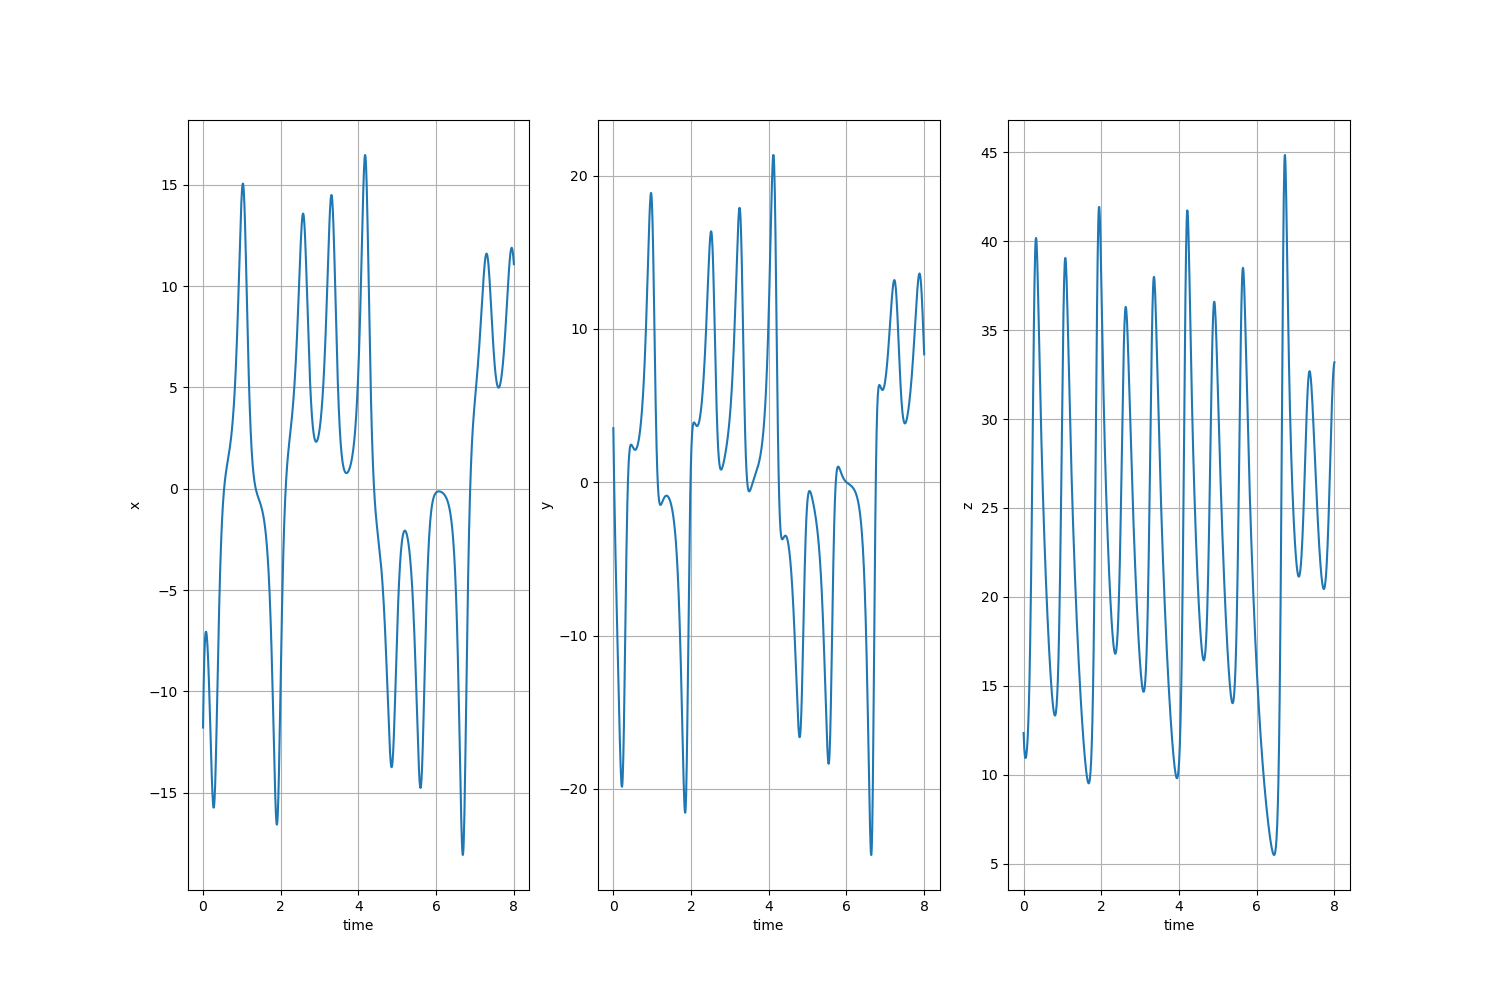

In [11]:
# plot components
plot_components(X, Y)

## Define the model
This is inspired by the tuned model on DHO

In [12]:
# Model class
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 3))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [13]:
n_layers = 4
n_neurons = 28
n_epochs = 10000
# create model
model = FFNN(n_layers, n_neurons)

## Train

In [39]:
history_PINN = []

In [40]:
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# add minimun to lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=1000, min_lr=1e-5)

# define the loss function, L2
loss_fn = torch.nn.MSELoss()


In [47]:
# select only time < 2
X_sub = X[X<0.26]
Y_sub = Y[X<0.26]

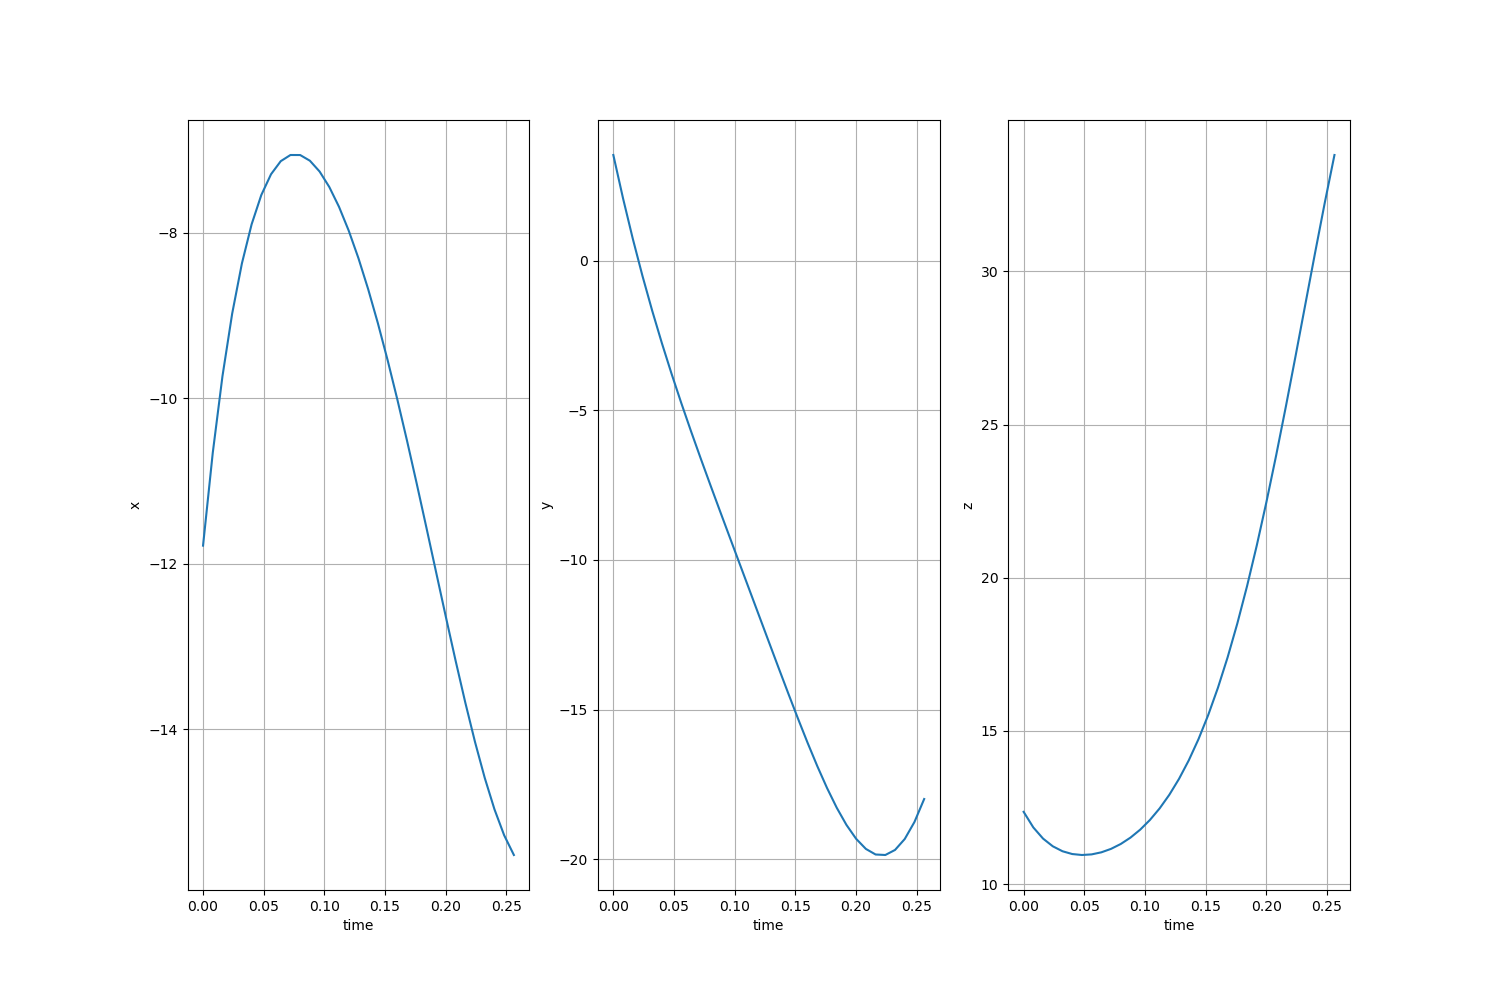

In [48]:
# plot components
plot_components(X_sub, Y_sub)

In [49]:
# to torch
X_sub_t = torch.tensor(X_sub, dtype=torch.float32).view(-1, 1)
Y_sub_t = torch.tensor(Y_sub, dtype=torch.float32)


In [50]:
%%time

for epoch in range(250000):
    optimizer.zero_grad()
    X_sub_t.requires_grad = True
    Y_pred = model(X_sub_t)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 10 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = loss_fn(dx_dt_pred[:,0], dx_dt_ode) + loss_fn(dy_dt_pred[:,0], dy_dt_ode) + loss_fn(dz_dt_pred[:,0], dz_dt_ode)

    # add loss ic
    loss_ic = torch.mean((Y_pred[0] - Y_sub_t[0])**2)

    loss = 20*loss_ode + loss_ic

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    history_PINN.append([loss.item(), loss_ode.detach().numpy(), loss_ic.detach().numpy(), optimizer.param_groups[0]["lr"]])    

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}, lr {optimizer.param_groups[0]["lr"]}')

Epoch 0, Loss 184343.0, lr 0.00020971520000000012
Epoch 1000, Loss 15.84683609008789, lr 0.0001677721600000001
Epoch 2000, Loss 14.460508346557617, lr 0.00013421772800000008
Epoch 3000, Loss 13.917500495910645, lr 0.00010737418240000007
Epoch 4000, Loss 13.49157428741455, lr 8.589934592000007e-05
Epoch 5000, Loss 13.056259155273438, lr 6.871947673600006e-05
Epoch 6000, Loss 12.534348487854004, lr 5.497558138880005e-05
Epoch 7000, Loss 11.450820922851562, lr 4.3980465111040044e-05
Epoch 8000, Loss 10.07140064239502, lr 3.5184372088832036e-05
Epoch 9000, Loss 9.427688598632812, lr 2.814749767106563e-05
Epoch 10000, Loss 8.84717082977295, lr 2.2517998136852506e-05
Epoch 11000, Loss 8.392539024353027, lr 1.8014398509482006e-05
Epoch 12000, Loss 8.087870597839355, lr 1.4411518807585605e-05
Epoch 13000, Loss 7.829531192779541, lr 1.1529215046068485e-05
Epoch 14000, Loss 7.587313175201416, lr 1e-05
Epoch 15000, Loss 7.341098308563232, lr 1e-05
Epoch 16000, Loss 7.087306499481201, lr 1e-05
Epo

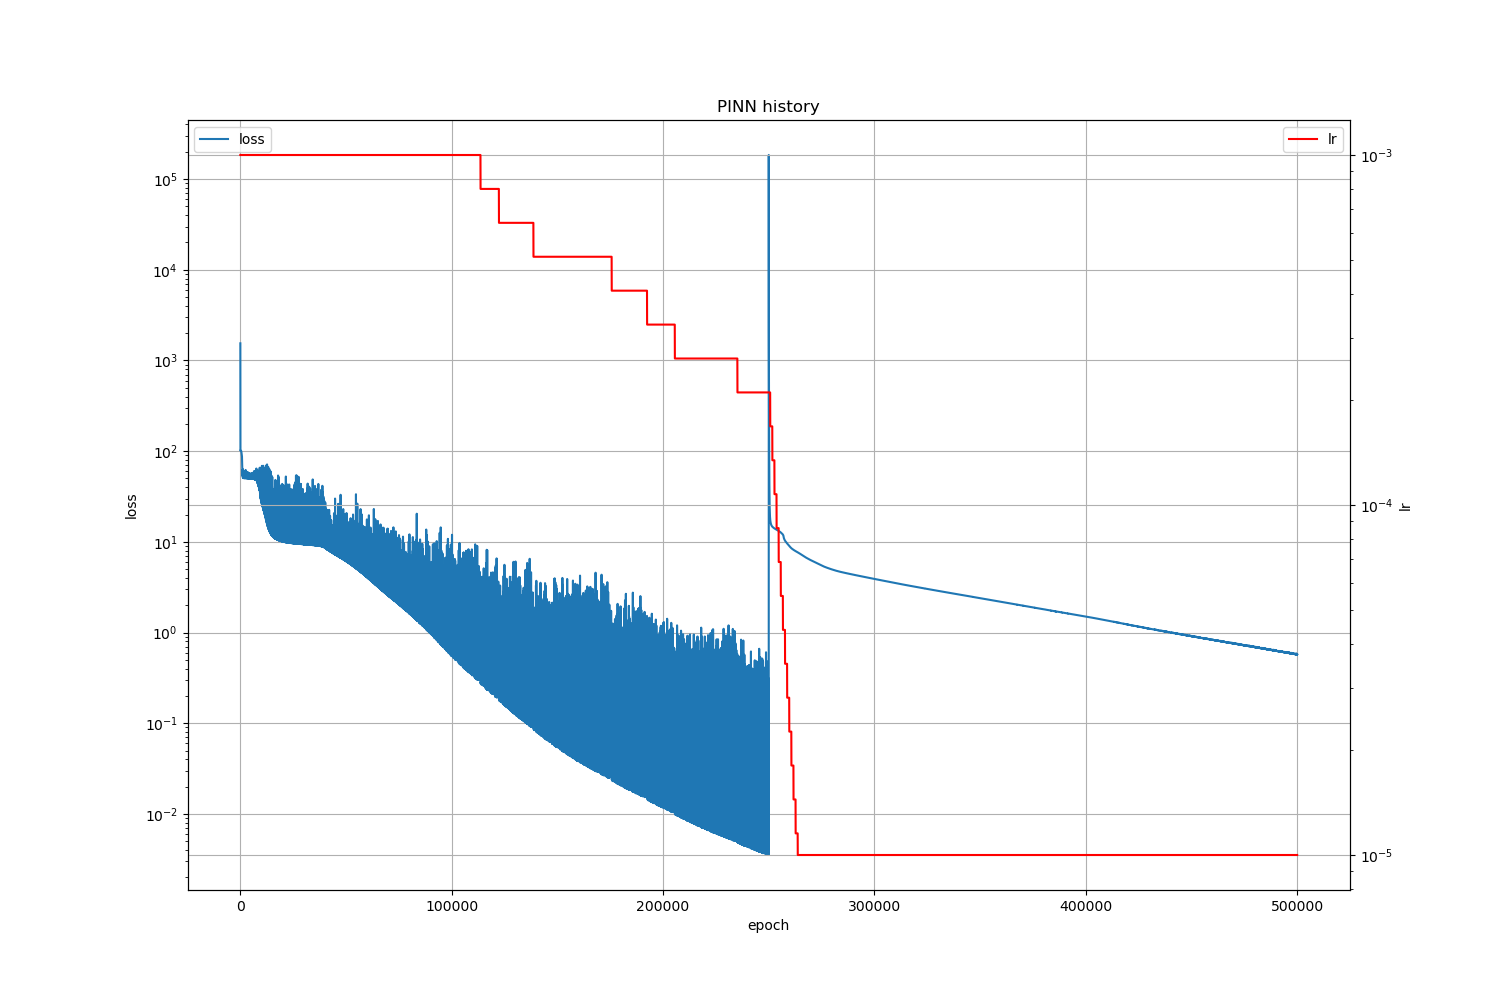

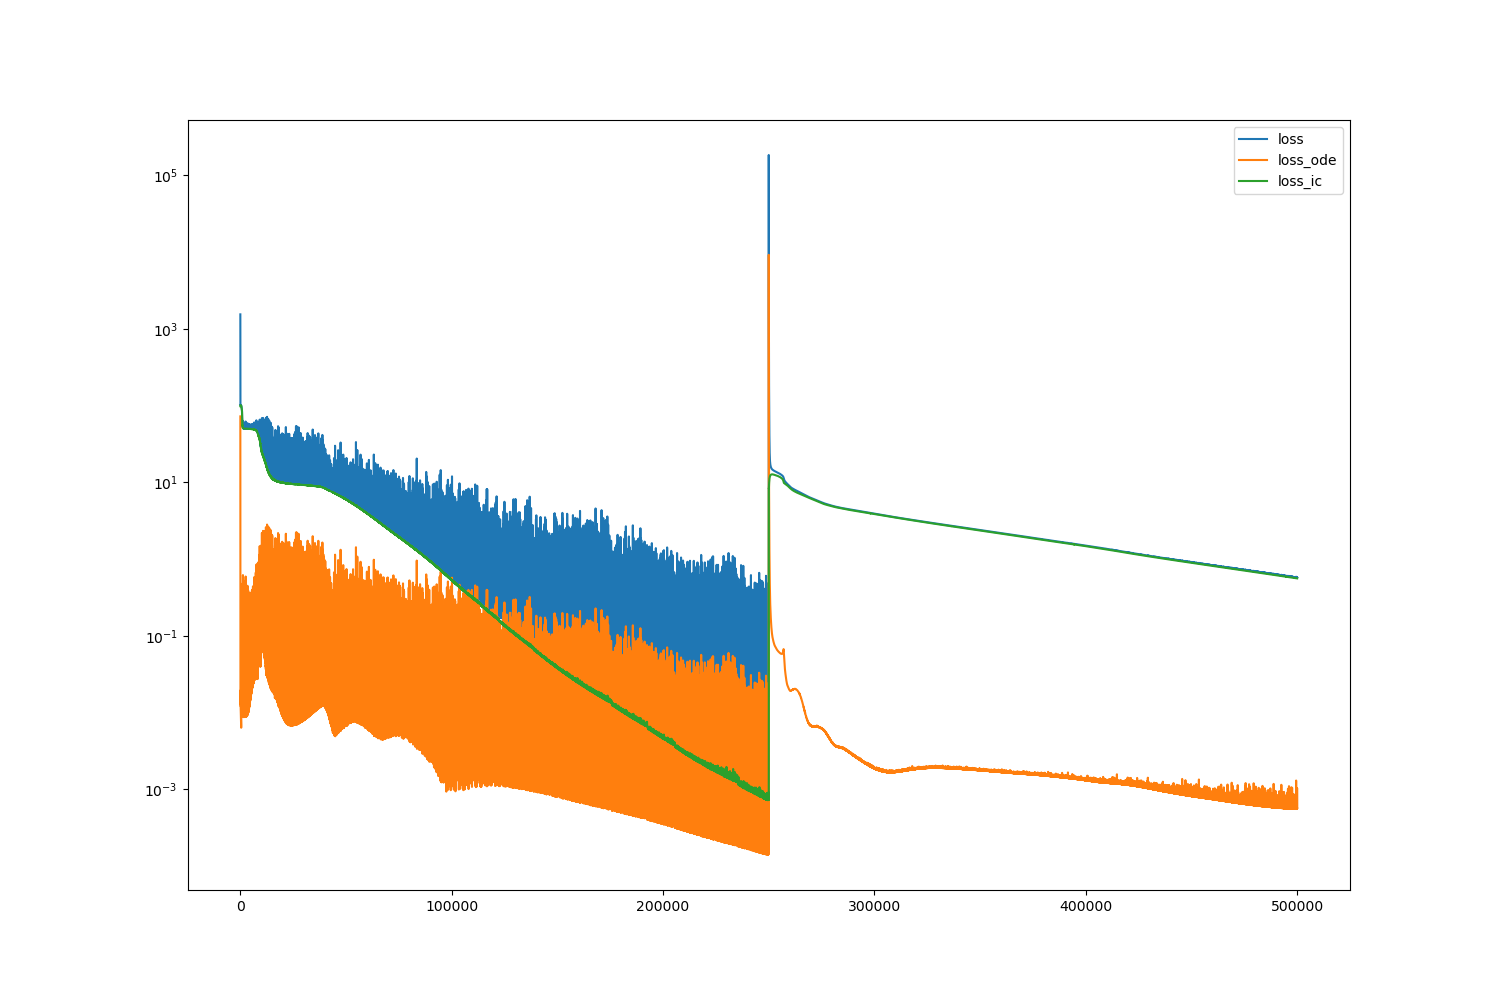

In [51]:
# plot history_PINN loss and lr in two subplots
history_PINN = np.array(history_PINN)

fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_PINN[:, 0], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_PINN[:, -1], label='lr', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('PINN history')


# plot losses
plt.figure(figsize=(15, 10))
plt.plot(history_PINN[:, 0], label='loss')
plt.plot(history_PINN[:, 1], label='loss_ode')
plt.plot(history_PINN[:, 2], label='loss_ic')
plt.legend()
plt.yscale('log')

# history to list
history_PINN = history_PINN.tolist()

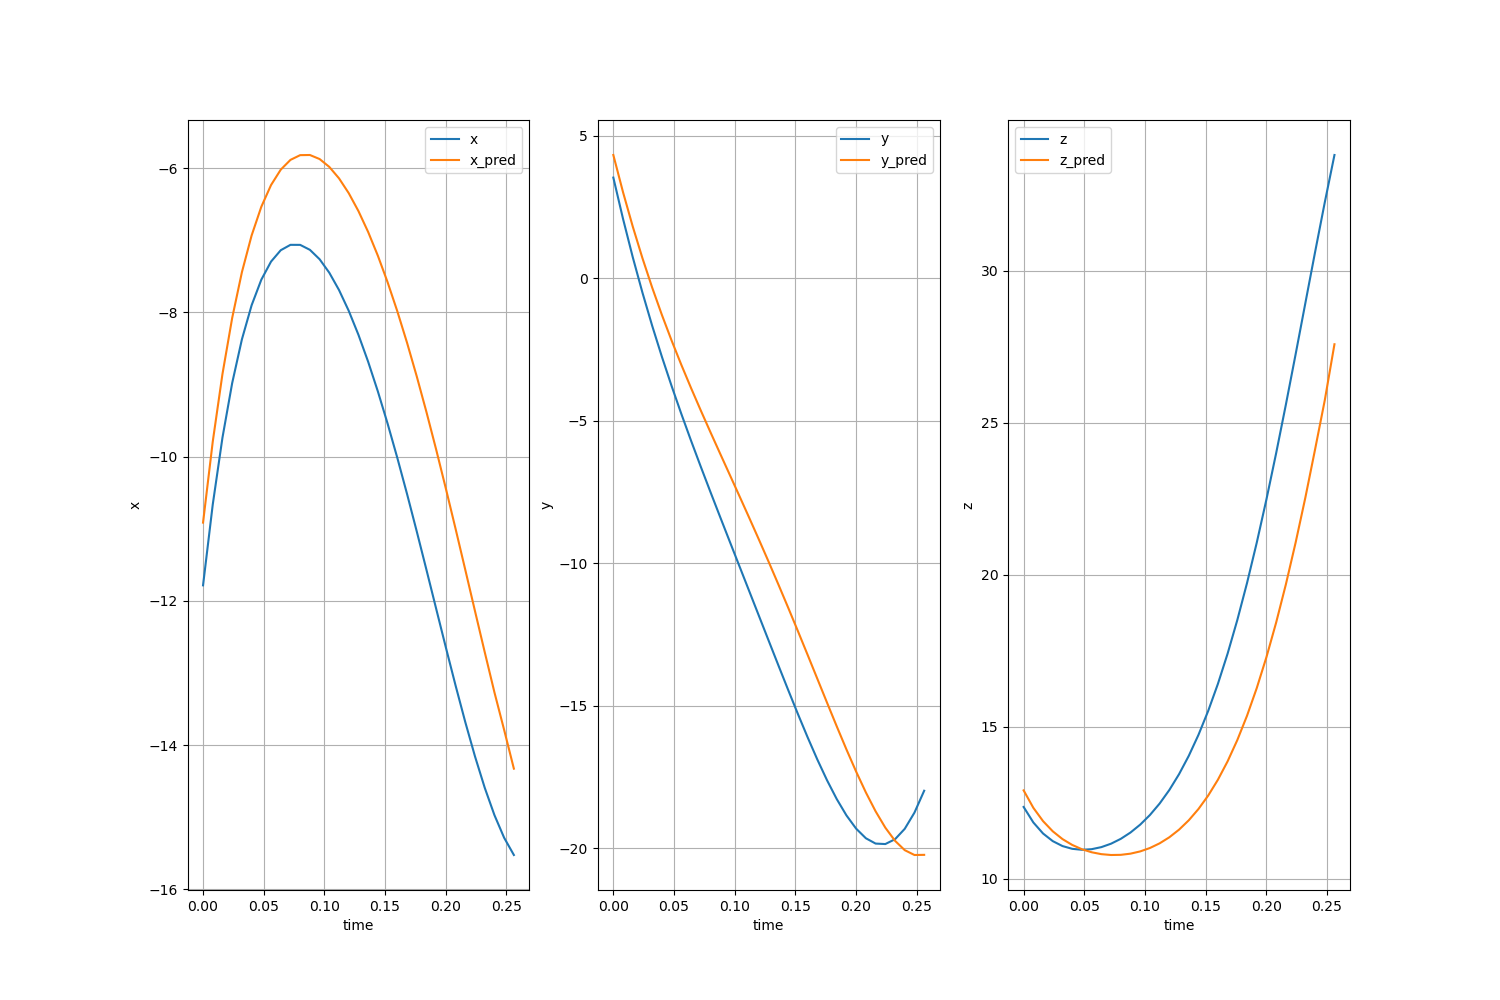

In [52]:
# get prediction and plot compare
Y_pred = model(X_sub_t).detach().numpy()
plot_compare_components(X_sub, Y_sub, Y_pred)

In [ ]:
8/1000

0.008

In [ ]:
0.025/0.008

3.125

In [ ]:
history_PINN = np.array(history_PINN)
# get losses
losses = history_PINN[:, 0]
losses_ode = history_PINN[:, 1]
losses_ic = history_PINN[:, 2]

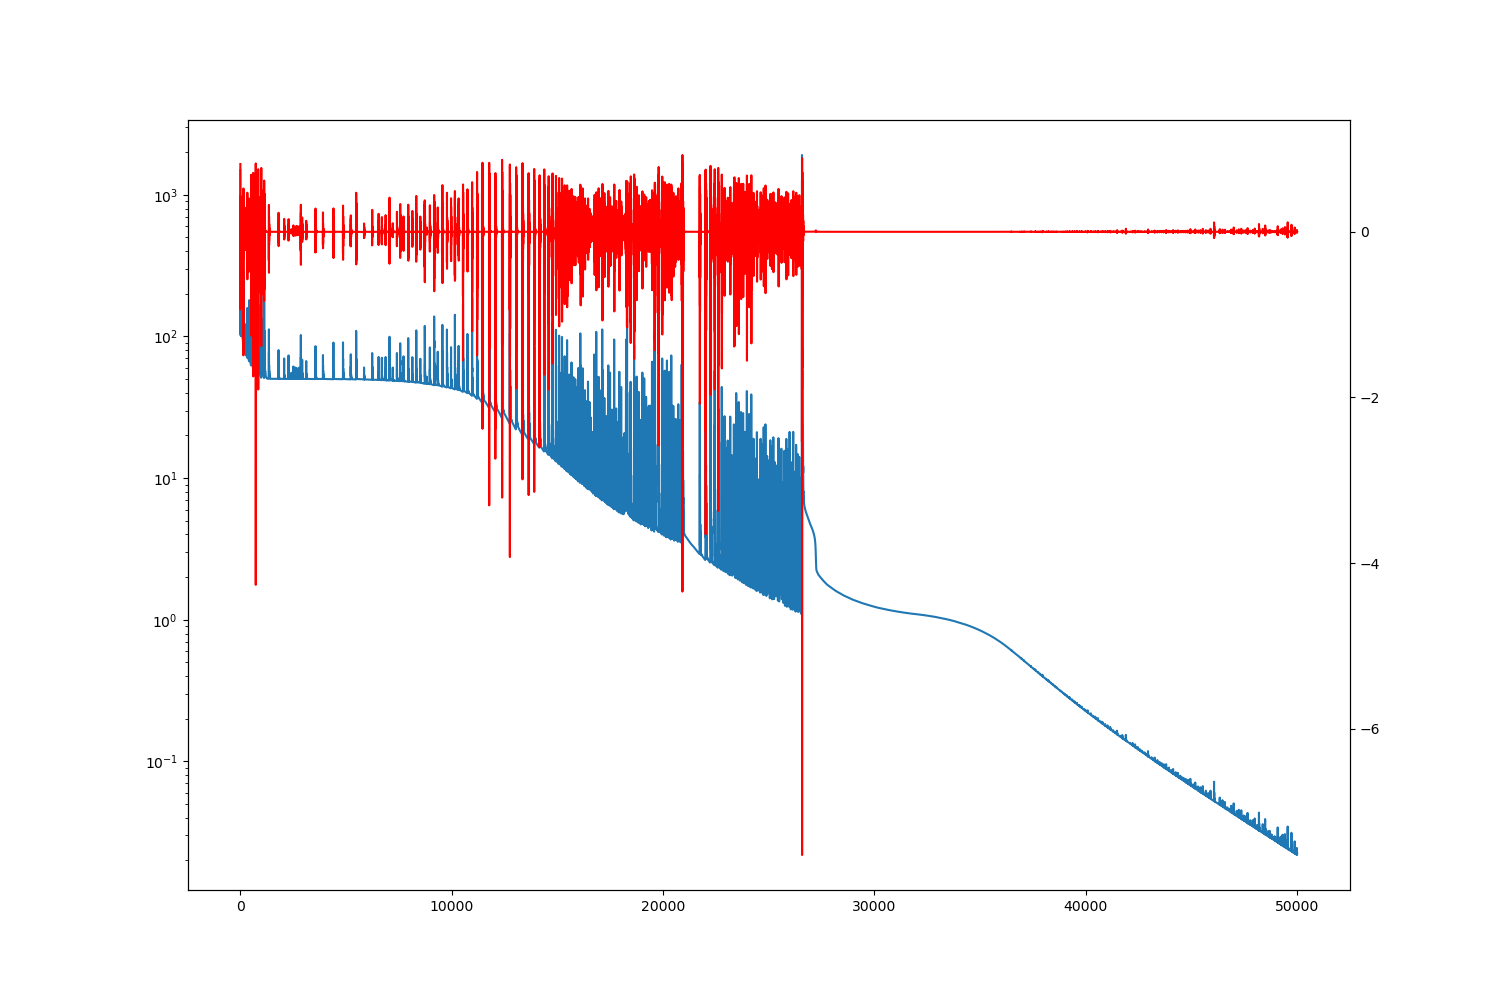

In [ ]:
# get derivative of the losses
d_losses = np.diff(losses)
d_losses_ode = np.diff(losses_ode)
d_losses_ic = np.diff(losses_ic)

# get normalized derivative of the losses
d_losses_norm = d_losses / losses[:-1]
d_losses_ode_norm = d_losses_ode / losses_ode[:-1]
d_losses_ic_norm = d_losses_ic / losses_ic[:-1]

# twin plot of the losses and in the other axis the derivative of the losses
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(losses, label='loss')
plt.yscale('log')

ax2 = ax.twinx()
ax2.plot(-d_losses_norm, label='d_loss', color='r')


In [ ]:
d_losses_ode

array([-6.13320007e+01,  2.10404396e-01, -5.50914526e+00, ...,
        6.33057061e-06,  5.48219396e-06,  1.55865564e-06])

In [ ]:
# plot d_losses_ode
plt.figure(figsize=(15, 10))
plt.plot(d_losses_ode, label='d_losses_ode')
plt.yscale('log')

: 

In [ ]:
# new model
model2 = FFNN(n_layers, n_neurons)


# history_PINN2
history_PINN2 = []

In [ ]:
# define the optimizer2 and scheduler2
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', factor=0.7, patience=1000, min_lr=1e-4)


In [ ]:
# select only time < 2
X_sub2 = X[X<1]
Y_sub2 = Y[X<1]

# to torch
X_sub_t2 = torch.tensor(X_sub2, dtype=torch.float32).view(-1, 1)
Y_sub_t2 = torch.tensor(Y_sub2, dtype=torch.float32)

In [ ]:
# train model2 for 250000

for epoch in range(8*250000):
    optimizer2.zero_grad()
    X_sub_t2.requires_grad = True
    Y_pred2 = model2(X_sub_t2)

    # get the derivatives
    dx_dt_pred2 = torch.autograd.grad(Y_pred2[:,0], X_sub_t2, grad_outputs=torch.ones_like(Y_pred2[:,0]), create_graph=True)[0]
    dy_dt_pred2 = torch.autograd.grad(Y_pred2[:,1], X_sub_t2, grad_outputs=torch.ones_like(Y_pred2[:,1]), create_graph=True)[0]
    dz_dt_pred2 = torch.autograd.grad(Y_pred2[:,2], X_sub_t2, grad_outputs=torch.ones_like(Y_pred2[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode2 = 20 * (Y_pred2[:,1] - Y_pred2[:,0])
    dy_dt_ode2 = Y_pred2[:,0] * (28 - Y_pred2[:,2]) - Y_pred2[:,1]
    dz_dt_ode2 = Y_pred2[:,0] * Y_pred2[:,1] - 8/3 * Y_pred2[:,2]

    # loss ode
    loss_ode2 = loss_fn(dx_dt_pred2[:,0], dx_dt_ode2) + loss_fn(dy_dt_pred2[:,0], dy_dt_ode2) + loss_fn(dz_dt_pred2[:,0], dz_dt_ode2)

    # add loss ic
    loss_ic2 = torch.mean((Y_pred2[0] - Y_sub_t[0])**2)

    loss2 = 30*loss_ode2 + loss_ic2

    loss2.backward()
    optimizer2.step()
    scheduler2.step(loss2)

    history_PINN2.append([loss2.item(), loss_ode2.detach().numpy(), loss_ic2.detach().numpy(), optimizer2.param_groups[0]["lr"]])    

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss {loss2.item()}, lr {optimizer2.param_groups[0]["lr"]}')

Epoch 0, Loss 0.0496583953499794, lr 0.0001
Epoch 100, Loss 0.042317166924476624, lr 0.0001
Epoch 200, Loss 0.041283443570137024, lr 0.0001
Epoch 300, Loss 0.04121961072087288, lr 0.0001
Epoch 400, Loss 0.041163261979818344, lr 0.0001
Epoch 500, Loss 0.04109780862927437, lr 0.0001
Epoch 600, Loss 0.041031546890735626, lr 0.0001
Epoch 700, Loss 0.040961235761642456, lr 0.0001
Epoch 800, Loss 0.04088761284947395, lr 0.0001
Epoch 900, Loss 0.040812455117702484, lr 0.0001
Epoch 1000, Loss 0.0407286174595356, lr 0.0001
Epoch 1100, Loss 0.04068129137158394, lr 0.0001
Epoch 1200, Loss 0.040752947330474854, lr 0.0001
Epoch 1300, Loss 0.04048709571361542, lr 0.0001
Epoch 1400, Loss 0.051154155284166336, lr 0.0001
Epoch 1500, Loss 0.18976359069347382, lr 0.0001
Epoch 1600, Loss 0.04089624807238579, lr 0.0001
Epoch 1700, Loss 0.04016457498073578, lr 0.0001
Epoch 1800, Loss 0.04789980500936508, lr 0.0001
Epoch 1900, Loss 0.07354164123535156, lr 0.0001
Epoch 2000, Loss 0.03986619412899017, lr 0.000

KeyboardInterrupt: 

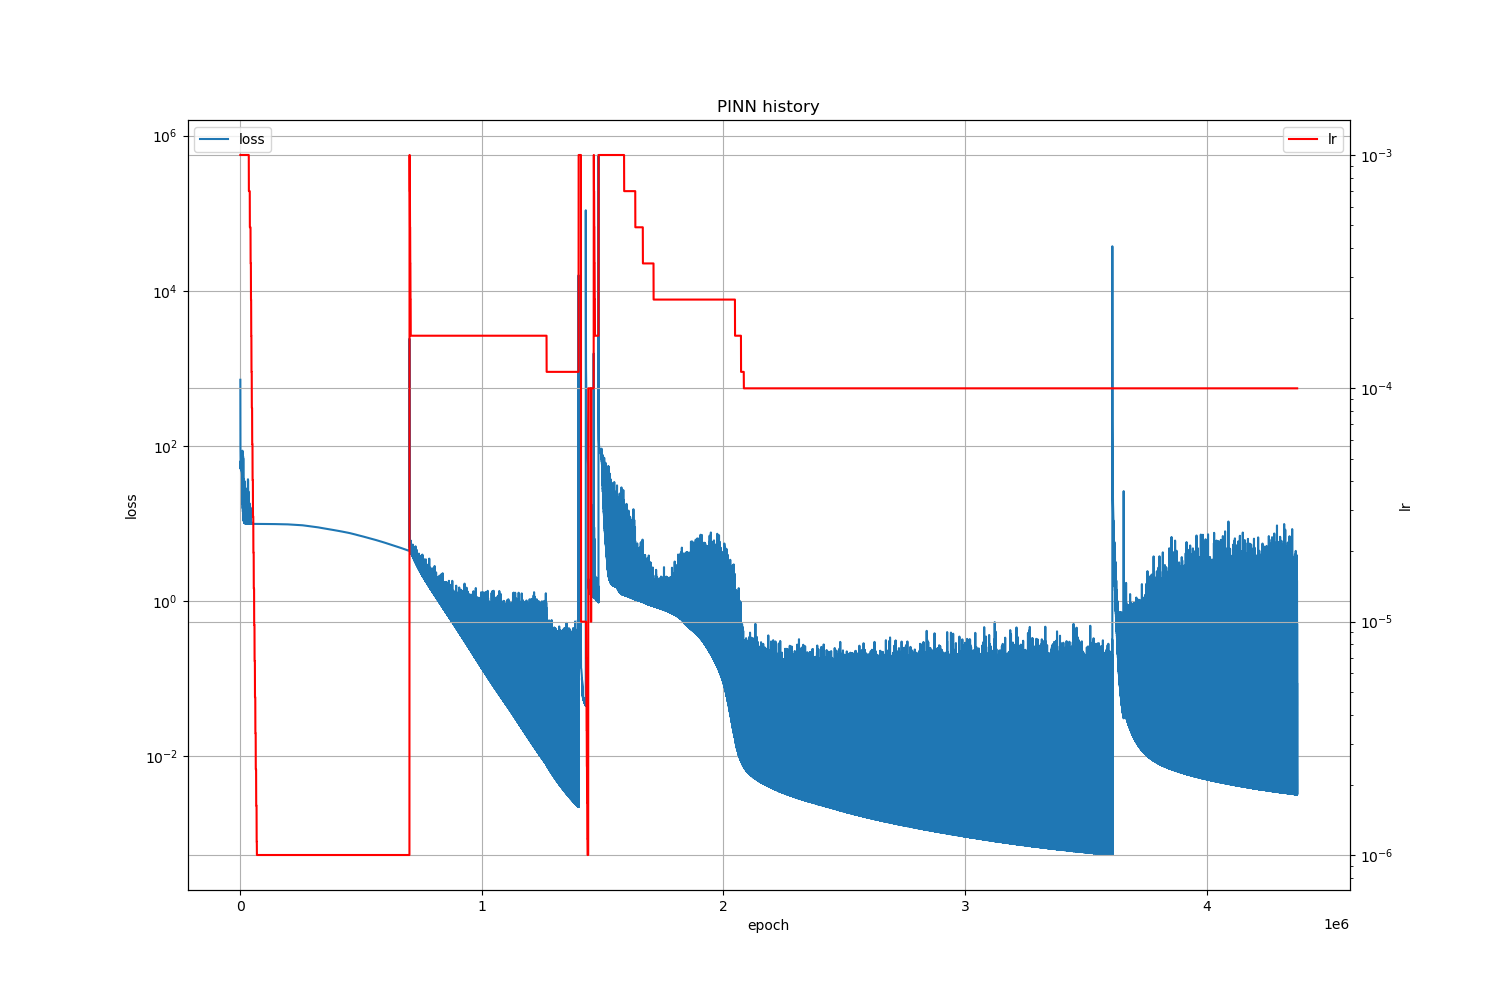

In [ ]:
# plot history_PINN2 loss and lr in two subplots
history_PINN2 = np.array(history_PINN2)
if True:
    fig, ax = plt.subplots(figsize=(15, 10))
    # plot the loss
    ax.plot(history_PINN2[:, 0], label='loss')
    ax.legend(loc='upper left')
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.grid()

    # plot the learning rate
    ax2 = ax.twinx()
    ax2.plot(history_PINN2[:, -1], label='lr', color='r')
    ax2.set_yscale('log')
    ax2.set_ylabel('lr')
    # legend to the right
    ax2.legend(loc='upper right')
    plt.grid()
    plt.title('PINN history')

# history to list
history_PINN2 = history_PINN2.tolist()

In [58]:
# load PINN_Lorenz_model_14_3_T_0_0.25.pt
model2 = torch.load('../models/PINN_Lorenz_model_14_3_T_0_0.25.pt')

In [64]:
# select only0.25time < 2
X_sub2 = X[X<0.25]
Y_sub2 = Y[X<0.25]

# to torch
X_sub_t2 = torch.tensor(X_sub2, dtype=torch.float32).view(-1, 1)
Y_sub_t2 = torch.tensor(Y_sub2, dtype=torch.float32)

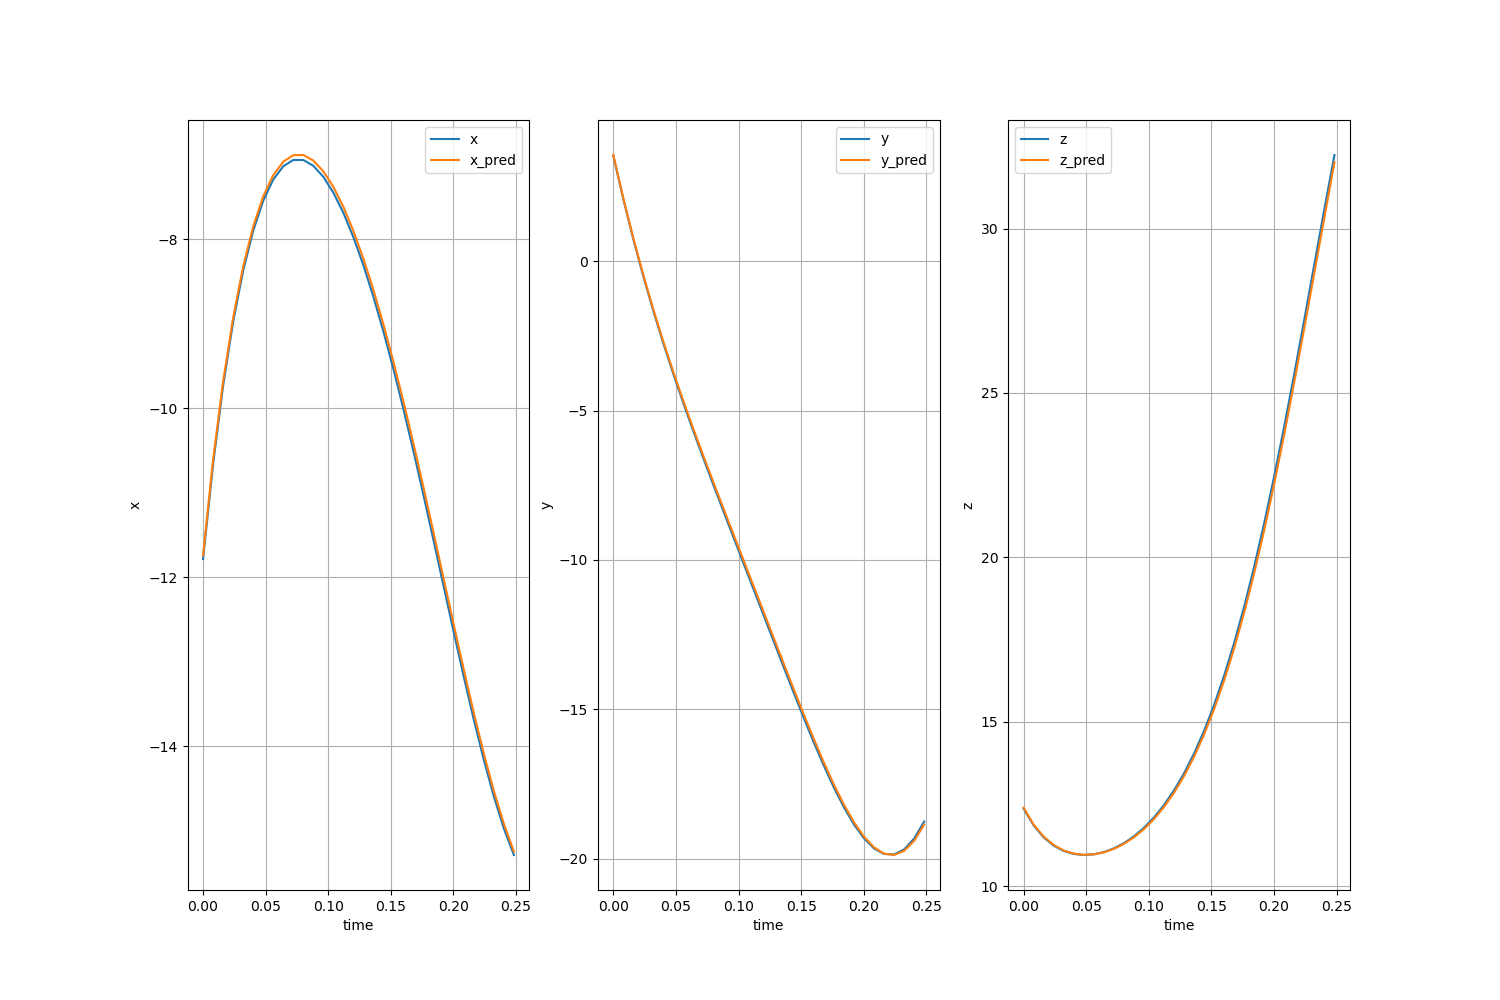

In [65]:
# show prediction
if True:
    Y_pred2 = model2(X_sub_t2).detach().numpy()
    plot_compare_components(X_sub2, Y_sub2, Y_pred2)

In [66]:
# load 
loss_fn = torch.nn.MSELoss()

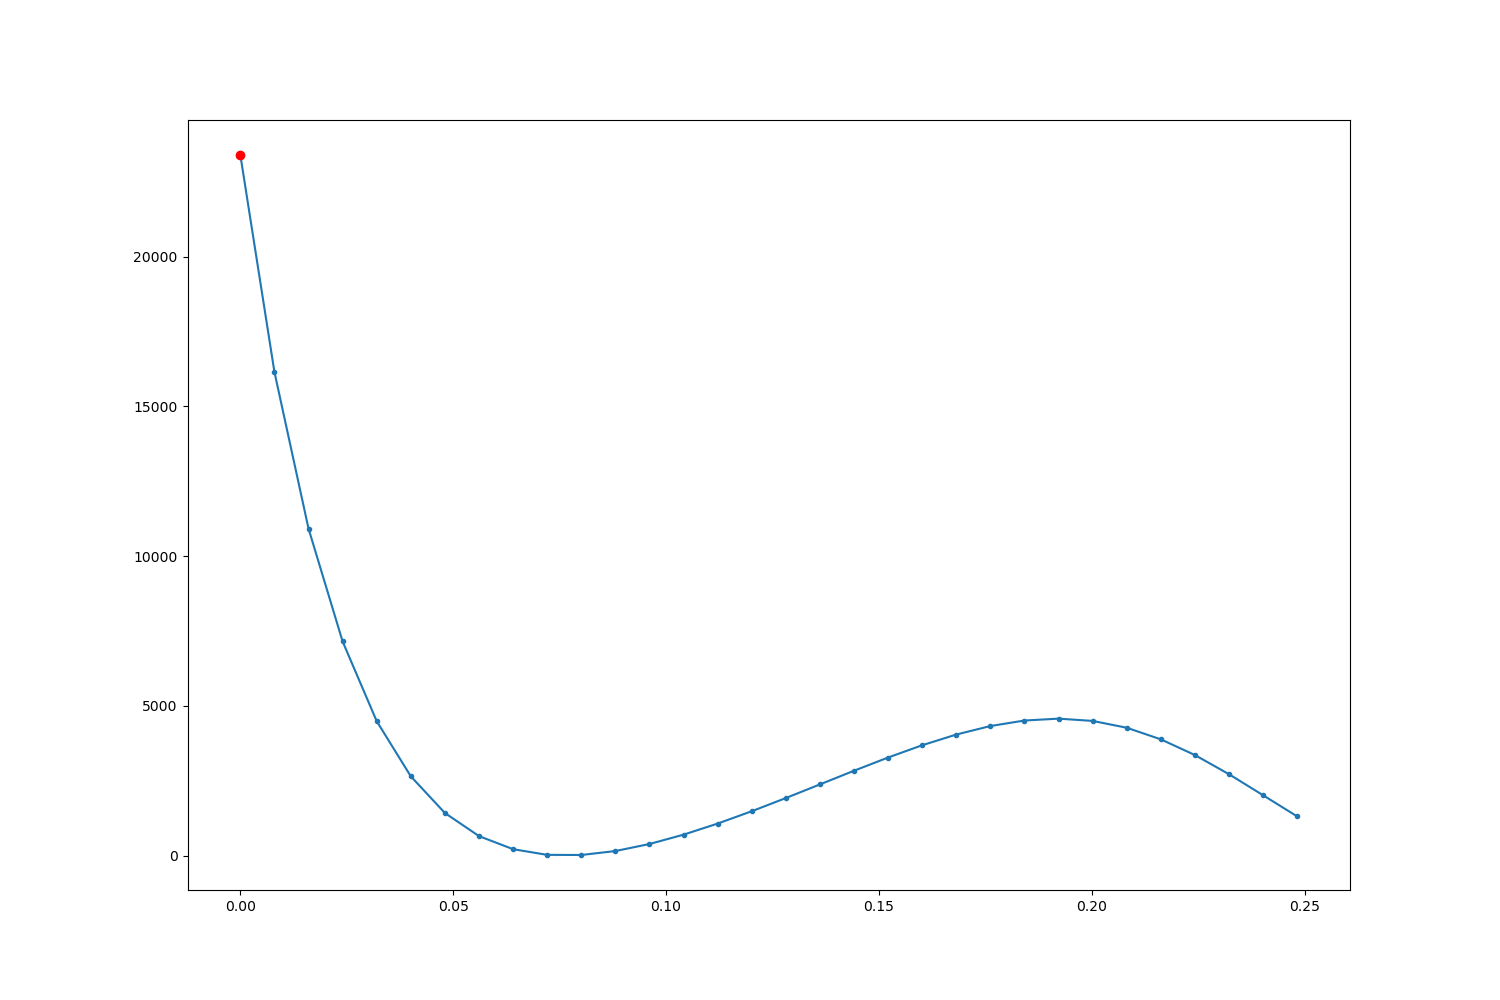

In [67]:
X_sub_t2.requires_grad = True
Y_pred2 = model2(X_sub_t2)

dx_dt_pred2 = torch.autograd.grad(Y_pred2[:,0], X_sub_t2, grad_outputs=torch.ones_like(Y_pred2[:,0]), create_graph=True)[0]
dy_dt_pred2 = torch.autograd.grad(Y_pred2[:,1], X_sub_t2, grad_outputs=torch.ones_like(Y_pred2[:,1]), create_graph=True)[0]
dz_dt_pred2 = torch.autograd.grad(Y_pred2[:,2], X_sub_t2, grad_outputs=torch.ones_like(Y_pred2[:,2]), create_graph=True)[0]

# get true derivatives, using the lorenz parameter
dx_dt_ode2 = 20 * (Y_pred2[:,1] - Y_pred2[:,0])
dy_dt_ode2 = Y_pred2[:,0] * (28 - Y_pred2[:,2]) - Y_pred2[:,1]
dz_dt_ode2 = Y_pred2[:,0] * Y_pred2[:,1] - 8/3 * Y_pred2[:,2]

# loss ode
loss_ode_1 = (dx_dt_pred2[:,0]- dx_dt_ode2)**2 + (dy_dt_pred2[:,0]- dy_dt_ode2)**2 + loss_fn(dz_dt_pred2[:,0], dz_dt_ode2)**2

# plot loss_ode_1
plt.figure(figsize=(15, 10))
plt.plot(X_sub_t2.detach().numpy(),loss_ode_1.detach().numpy(), label='loss_ode_1',marker='.')

# get the maximum index, and plot a red dot
max_index = np.argmax(loss_ode_1.detach().numpy())
plt.plot(X_sub_t2.detach().numpy()[max_index], loss_ode_1.detach().numpy()[max_index], 'ro')


# def a function called ode_loss
def lorenz_loss_ode(model, X):
    """
    This function calculates the loss of the ode for the Lorenz system
    as a function of the input tensor X (time).
    Parameters:
    model (torch.nn.Module): the model
    X (torch.tensor): the input tensor
    """

    X.requires_grad = True
    Y_pred = model(X)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 20 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = (dx_dt_pred[:,0]- dx_dt_ode)**2 + (dy_dt_pred[:,0]- dy_dt_ode)**2 + (dz_dt_pred[:,0]- dz_dt_ode)**2

    return loss_ode

In [63]:
max_index = 30

X_sub2[max_index]

0.24024024024024024

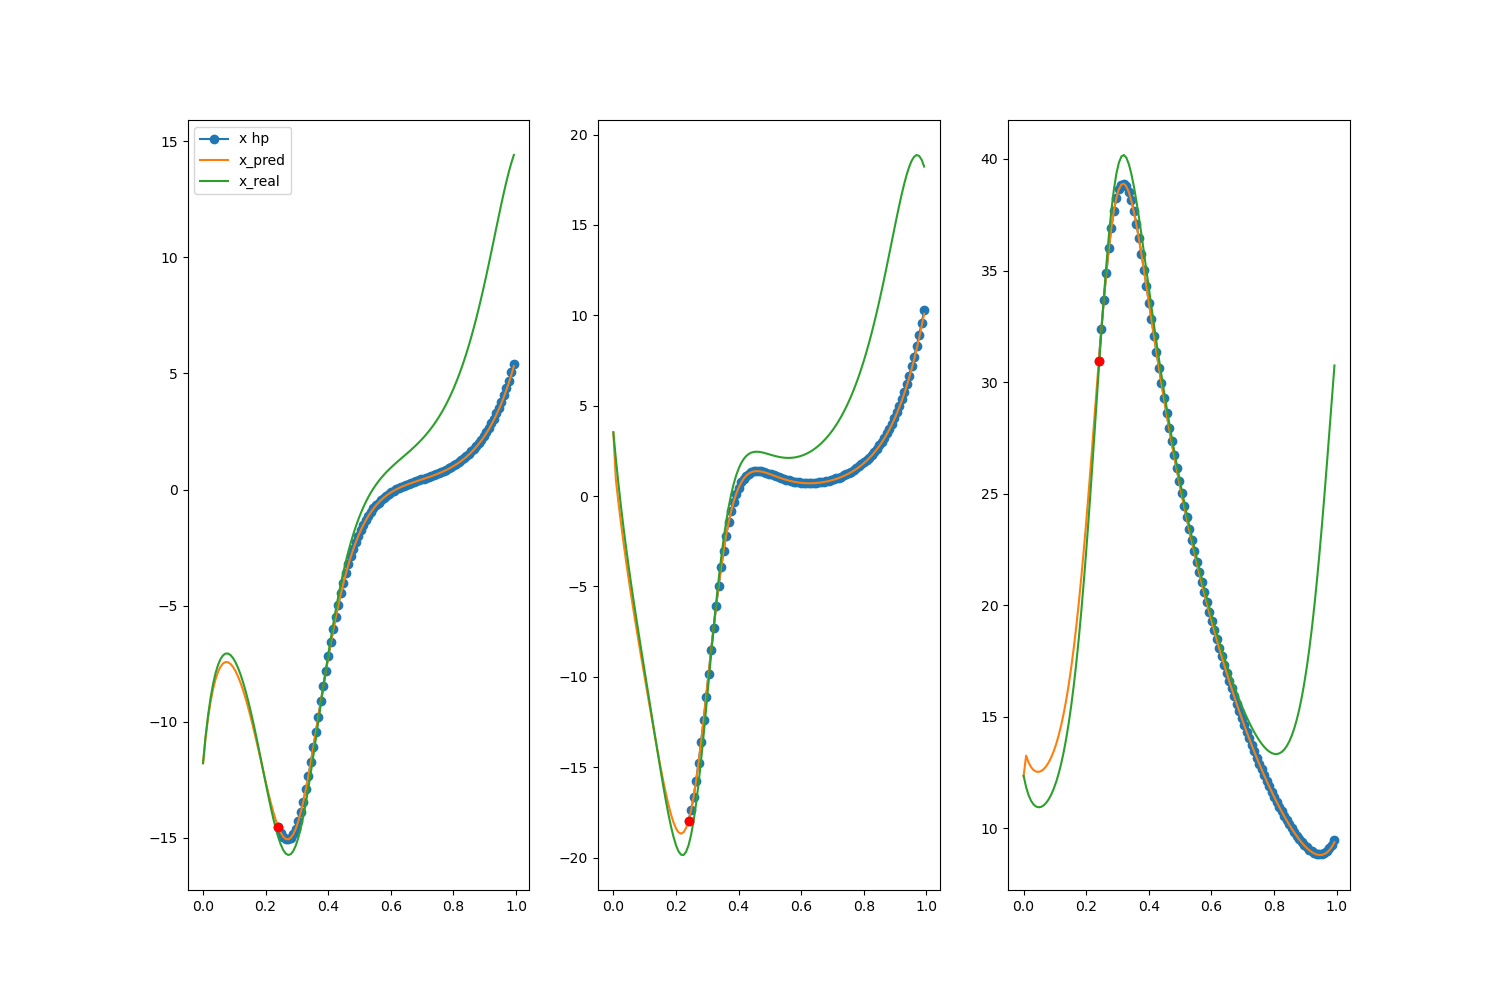

In [56]:
# get the predicted state for the maximum index
Y_pred2[max_index]
# evove with the lorenz function, use scipy ivp_solve
sol_max = sp.integrate.solve_ivp(lorenz, [X_sub2[max_index], 1], Y_pred2.detach().numpy()[max_index], t_eval=X_sub2[max_index:])

# plot the solution
plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.plot(sol_max.t, sol_max.y[0], label='x hp', marker='o')
# plot the predicted solution
plt.plot(X_sub2, Y_pred2.detach().numpy()[:,0], label='x_pred')
# plot x real
plt.plot(X_sub2, Y_sub2[:,0], label='x_real')
# red dot in the maximum index
plt.plot(X_sub2[max_index], Y_pred2.detach().numpy()[max_index,0], 'ro')
plt.legend()

# do all the same for y
plt.subplot(132)
plt.plot(sol_max.t, sol_max.y[1], label='y hp', marker='o')
plt.plot(X_sub2, Y_pred2.detach().numpy()[:,1], label='y_pred')
plt.plot(X_sub2, Y_sub2[:,1], label='y_real')
plt.plot(X_sub2[max_index], Y_pred2.detach().numpy()[max_index,1], 'ro')

# do all the same for z
plt.subplot(133)
plt.plot(sol_max.t, sol_max.y[2], label='z hp', marker='o')
plt.plot(X_sub2, Y_pred2.detach().numpy()[:,2], label='z_pred')
plt.plot(X_sub2, Y_sub2[:,2], label='z_real')
plt.plot(X_sub2[max_index], Y_pred2.detach().numpy()[max_index,2], 'ro')




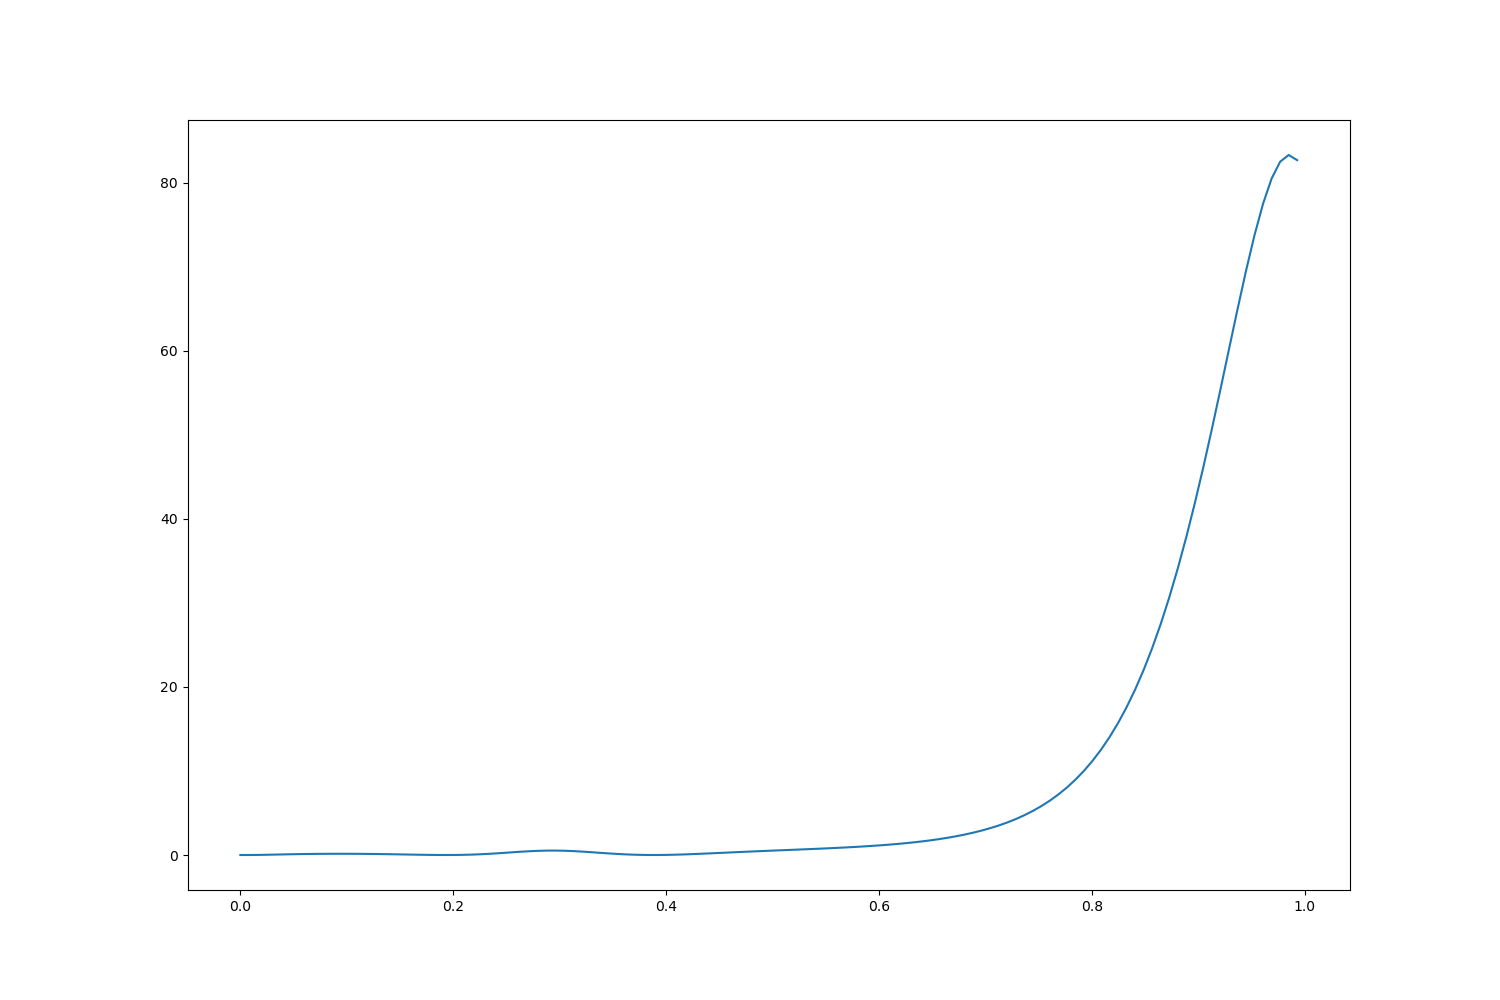

In [57]:
# get the vector of square differences between the Y_sub and Y_pred2
diffs = (Y_sub2 - Y_pred2.detach().numpy())**2

# plot the diffs
plt.figure(figsize=(15, 10))
plt.plot(X_sub2, diffs[:,0], label='diffs_x')

## expanding timeseries while learning

b

In [97]:



# make new model 
history_PINN3 = []

model3 = FFNN(n_layers, n_neurons)



In [98]:
# define the optimizer2 and scheduler2
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)
scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', factor=0.7, patience=700, min_lr=1e-6)

In [99]:
num_points = 4
X_temp = X[:4]
Y_temp = Y[:4]
# to torch
X_temp_t = torch.tensor(X_temp, dtype=torch.float32).view(-1, 1)
Y_temp_t = torch.tensor(Y_temp, dtype=torch.float32)



In [100]:
num_points
epoch = 0

In [101]:
# import datetime
import datetime

In [118]:

while True:

    while True:

        X_temp = X[:num_points]
        Y_temp = Y[:num_points]
        # to torch
        X_temp_t = torch.tensor(X_temp, dtype=torch.float32).view(-1, 1)
        Y_temp_t = torch.tensor(Y_temp, dtype=torch.float32)




        optimizer3.zero_grad()
        X_temp_t.requires_grad = True
        Y_pred3 = model3(X_temp_t)

        # get the derivatives
        dx_dt_pred3 = torch.autograd.grad(Y_pred3[:,0], X_temp_t, grad_outputs=torch.ones_like(Y_pred3[:,0]), create_graph=True)[0]
        dy_dt_pred3 = torch.autograd.grad(Y_pred3[:,1], X_temp_t, grad_outputs=torch.ones_like(Y_pred3[:,1]), create_graph=True)[0]
        dz_dt_pred3 = torch.autograd.grad(Y_pred3[:,2], X_temp_t, grad_outputs=torch.ones_like(Y_pred3[:,2]), create_graph=True)[0]

        # get true derivatives, using the lorenz parameter
        dx_dt_ode3 = 10 * (Y_pred3[:,1] - Y_pred3[:,0])
        dy_dt_ode3 = Y_pred3[:,0] * (28 - Y_pred3[:,2]) - Y_pred3[:,1]
        dz_dt_ode3 = Y_pred3[:,0] * Y_pred3[:,1] - 8/3 * Y_pred3[:,2]

        # loss ode
        loss_ode3 = loss_fn(dx_dt_pred3[:,0], dx_dt_ode3) + loss_fn(dy_dt_pred3[:,0], dy_dt_ode3) + loss_fn(dz_dt_pred3[:,0], dz_dt_ode3)

        # add loss ic
        loss_ic3 = torch.mean((Y_pred3[0] - Y_temp_t[0])**2)

        loss3 = 20*loss_ode3 + loss_ic3

        loss3.backward()
        optimizer3.step()
        scheduler3.step(loss3)

        epoch = epoch + 1

        

        if epoch % 1000 == 0:
            history_PINN3.append([epoch, loss3.item(), loss_ode3.detach().numpy(), loss_ic3.detach().numpy(), optimizer3.param_groups[0]["lr"], num_points])
            print(f'Epoch {epoch}, Loss {loss3.item()}, lr {optimizer3.param_groups[0]["lr"]}')

        if loss3 < 0.01:
            break

    if num_points % 5 == 0:
        # save model with name as datatime and num_points
        date = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        torch.save(model3, f'../models/lorenz_{date}_{num_points}.pt')
        # save history_PINN3
        np.save(f'../models/lorenz_{date}_{num_points}_history.npy', history_PINN3)
        # print saved
        print(f'saved model and history_PINN3 for num_points = {num_points}')

    num_points = num_points + 1
    # print augmented num_points
    print(f'num_points = {num_points}')
    optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.00001)
    scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', factor=0.7, patience=700, min_lr=1e-6)

Epoch 16971000, Loss 0.02220809832215309, lr 1e-05
Epoch 16972000, Loss 0.021602638065814972, lr 1e-05
Epoch 16973000, Loss 0.02327902987599373, lr 1e-05
Epoch 16974000, Loss 0.02198074758052826, lr 1e-05
Epoch 16975000, Loss 0.02088441140949726, lr 1e-05
Epoch 16976000, Loss 0.020859751850366592, lr 1e-05
Epoch 16977000, Loss 0.02043279819190502, lr 1e-05
Epoch 16978000, Loss 0.02053828164935112, lr 1e-05
Epoch 16979000, Loss 0.019998161122202873, lr 1e-05
Epoch 16980000, Loss 0.019787048920989037, lr 1e-05
Epoch 16981000, Loss 0.019577916711568832, lr 1e-05
Epoch 16982000, Loss 0.01938035525381565, lr 1e-05
Epoch 16983000, Loss 0.019177958369255066, lr 1e-05
Epoch 16984000, Loss 0.018982291221618652, lr 1e-05
Epoch 16985000, Loss 0.018790142610669136, lr 1e-05
Epoch 16986000, Loss 0.018640929833054543, lr 1e-05
Epoch 16987000, Loss 0.018436625599861145, lr 1e-05
Epoch 16988000, Loss 0.019009094685316086, lr 1e-05
Epoch 16989000, Loss 0.0181620791554451, lr 1e-05
Epoch 16990000, Loss 

KeyboardInterrupt: 

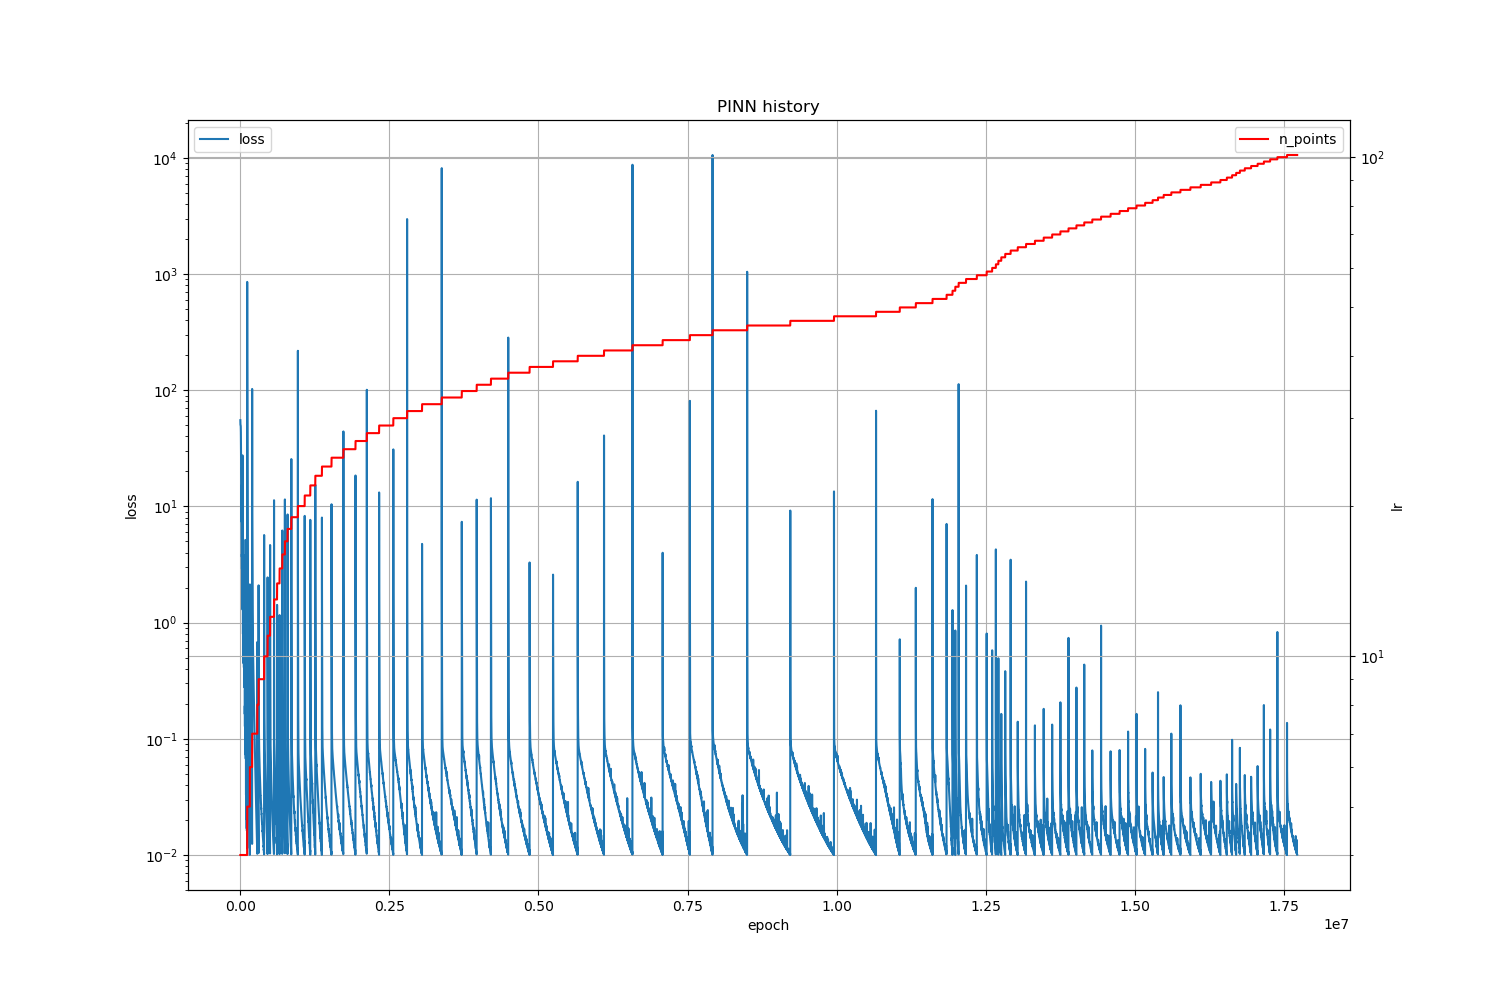

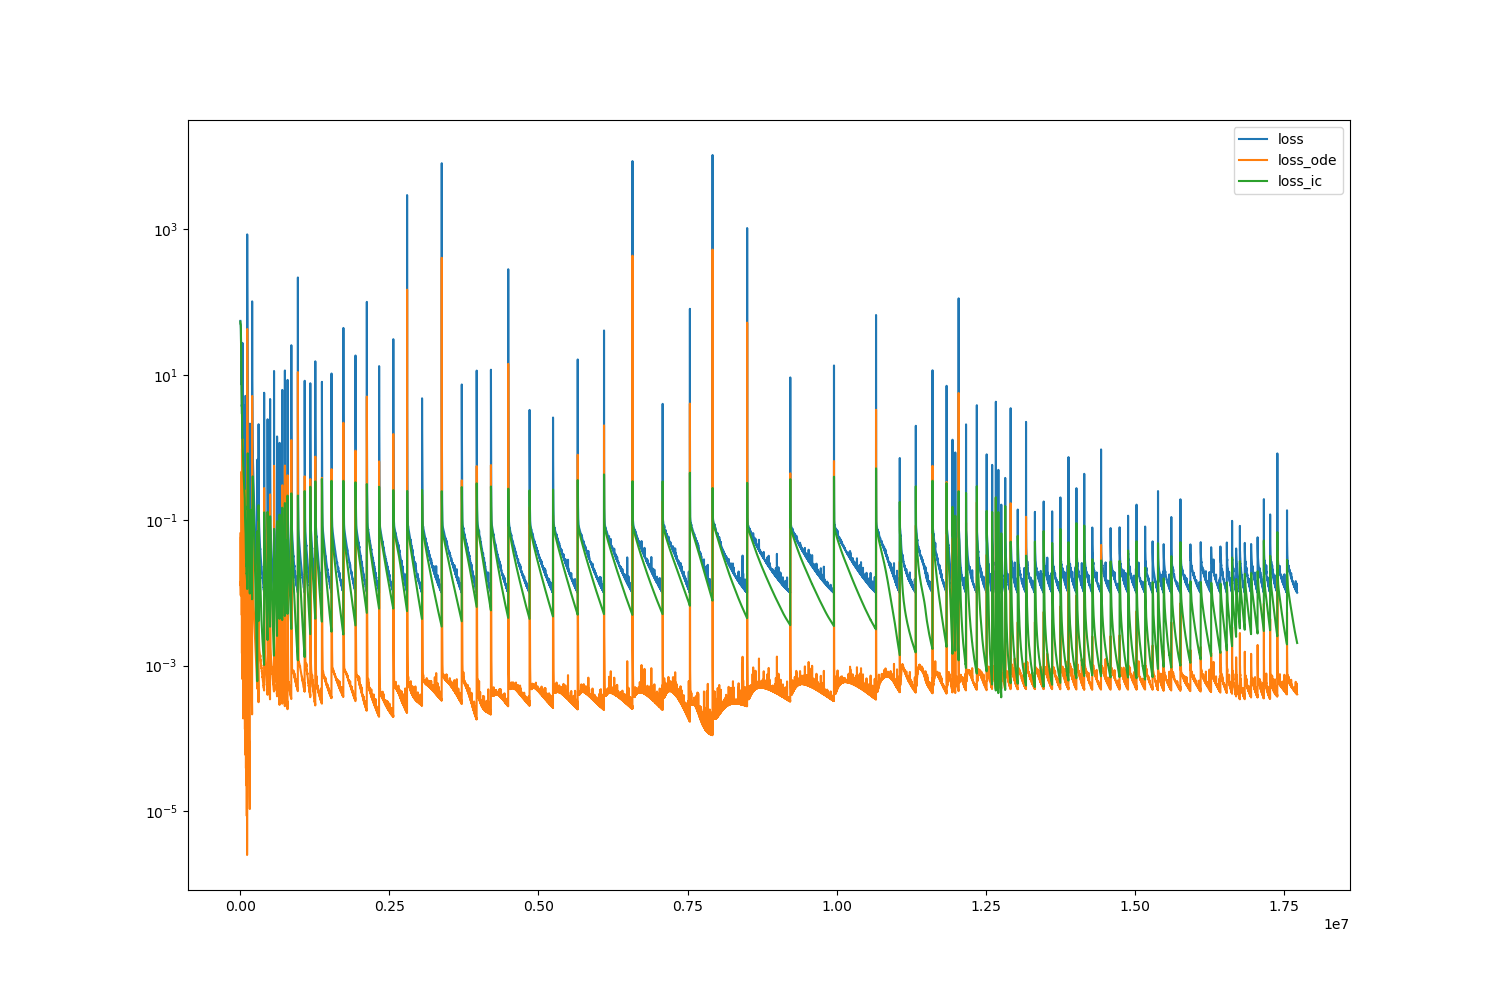

In [119]:
# plot history_PINN3 loss and lr in two subplots
history_PINN3 = np.array(history_PINN3)
fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_PINN3[:, 0],history_PINN3[:, 1], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_PINN3[:, 0], history_PINN3[:, -1], label='n_points', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('PINN history')

# new plot losses
plt.figure(figsize=(15, 10))
plt.plot(history_PINN3[:, 0], history_PINN3[:, 1], label='loss')
plt.plot(history_PINN3[:, 0], history_PINN3[:, 2], label='loss_ode')
plt.plot(history_PINN3[:, 0], history_PINN3[:, 3], label='loss_ic')
plt.legend()
plt.yscale('log')

# history to list
history_PINN3 = history_PINN3.tolist()

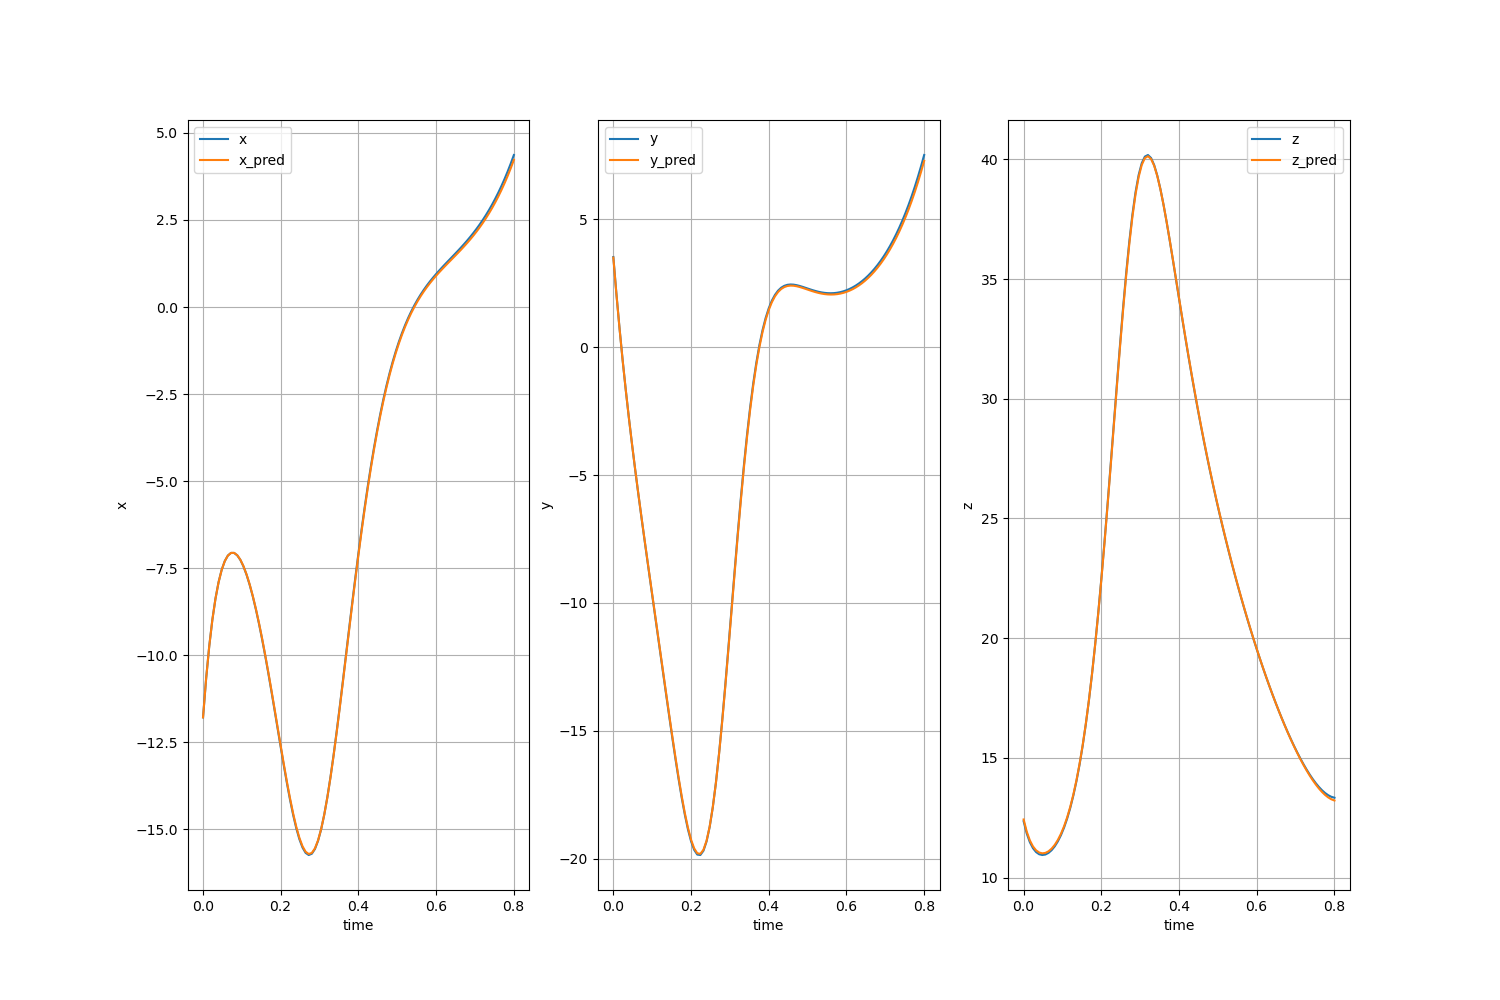

In [120]:
# show prediction
X_temp_t = torch.tensor(X_temp, dtype=torch.float32).view(-1, 1)
Y_temp_t = torch.tensor(Y_temp, dtype=torch.float32)
Y_pred3 = model3(X_temp_t).detach().numpy()
plot_compare_components(X_temp_t, Y_temp_t, Y_pred3)


In [ ]:
model4 = FFNN(n_layers, n_neurons)


In [ ]:
history_PINN4 = []


In [ ]:


# define the optimizer2 and scheduler2
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.01)
scheduler4 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer4, 'min', factor=0.7, patience=700, min_lr=1e-6)


In [ ]:
# define X_sub
X_sub = X[X<0.13]
Y_sub = Y[X<0.13]

In [ ]:
# redo all for model4





# select only time < 2, random points
X_sub4 = 0.12*np.random.rand(10000)
# set the first point to 0
X_sub4[0] = 0
Y_sub4 = np.random.rand(10000, 3)
# set the first point to the lorenz attractor
Y_sub4[0] = Y[0]

# to torch
X_sub_t4 = torch.tensor(X_sub4, dtype=torch.float32).view(-1, 1)
Y_sub_t4 = torch.tensor(Y_sub4, dtype=torch.float32)

for epoch in range(10000):

    optimizer4.zero_grad()
    X_sub_t4.requires_grad = True
    Y_pred4 = model4(X_sub_t4)

    # get the derivatives
    dx_dt_pred4 = torch.autograd.grad(Y_pred4[:,0], X_sub_t4, grad_outputs=torch.ones_like(Y_pred4[:,0]), create_graph=True)[0]
    dy_dt_pred4 = torch.autograd.grad(Y_pred4[:,1], X_sub_t4, grad_outputs=torch.ones_like(Y_pred4[:,1]), create_graph=True)[0]
    dz_dt_pred4 = torch.autograd.grad(Y_pred4[:,2], X_sub_t4, grad_outputs=torch.ones_like(Y_pred4[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode4 = 10 * (Y_pred4[:,1] - Y_pred4[:,0])
    dy_dt_ode4 = Y_pred4[:,0] * (28 - Y_pred4[:,2]) - Y_pred4[:,1]
    dz_dt_ode4 = Y_pred4[:,0] * Y_pred4[:,1] - 8/3 * Y_pred4[:,2]

    # loss ode
    loss_ode4 = loss_fn(dx_dt_pred4[:,0], dx_dt_ode4) + loss_fn(dy_dt_pred4[:,0], dy_dt_ode4) + loss_fn(dz_dt_pred4[:,0], dz_dt_ode4)

    # add loss ic
    loss_ic4 = torch.mean((Y_pred4[0] - Y_sub_t4[0])**2)

    loss4 = 20*loss_ode4 + loss_ic4

    loss4.backward()
    optimizer4.step()
    scheduler4.step(loss4)

    history_PINN4.append([loss4.item(), loss_ode4.detach().numpy(), loss_ic4.detach().numpy(), optimizer4.param_groups[0]["lr"]])

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss {loss4.item()}, lr {optimizer4.param_groups[0]["lr"]}')

Epoch 0, Loss 8.847977638244629, lr 0.01
Epoch 100, Loss 75.8065414428711, lr 0.01
Epoch 200, Loss 65.75528717041016, lr 0.01
Epoch 300, Loss 61.413734436035156, lr 0.01


KeyboardInterrupt: 

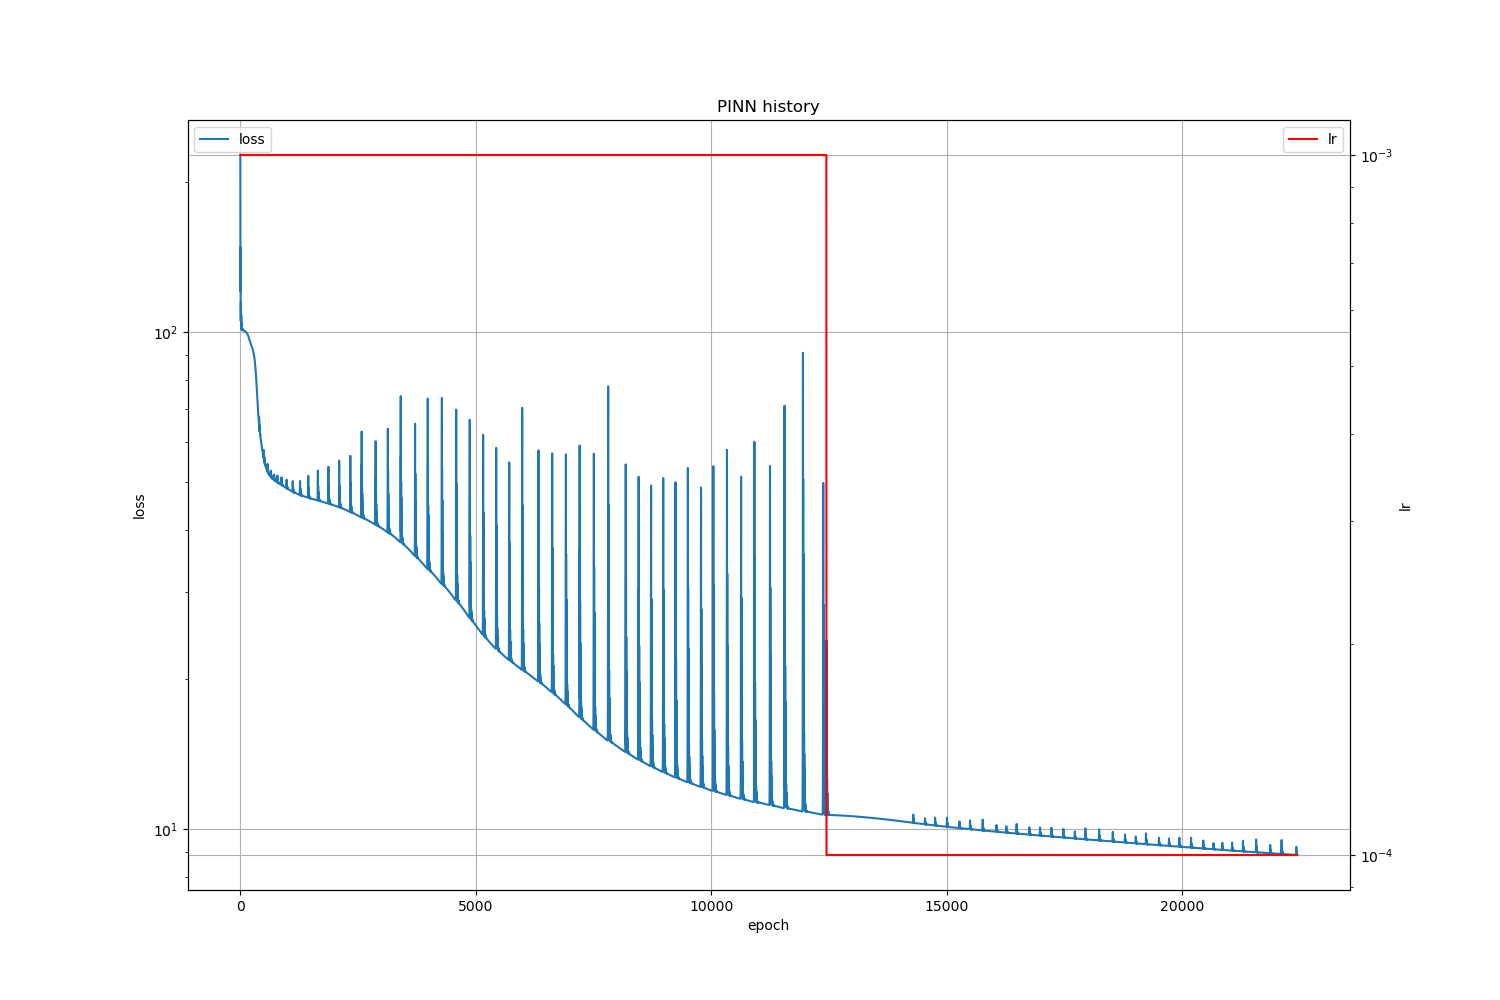

In [ ]:
# show history, suggetst all the code
history_PINN4 = np.array(history_PINN4)
fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_PINN4[:, 0], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_PINN4[:, -1], label='lr', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('PINN history')

# history to list
history_PINN4 = history_PINN4.tolist()

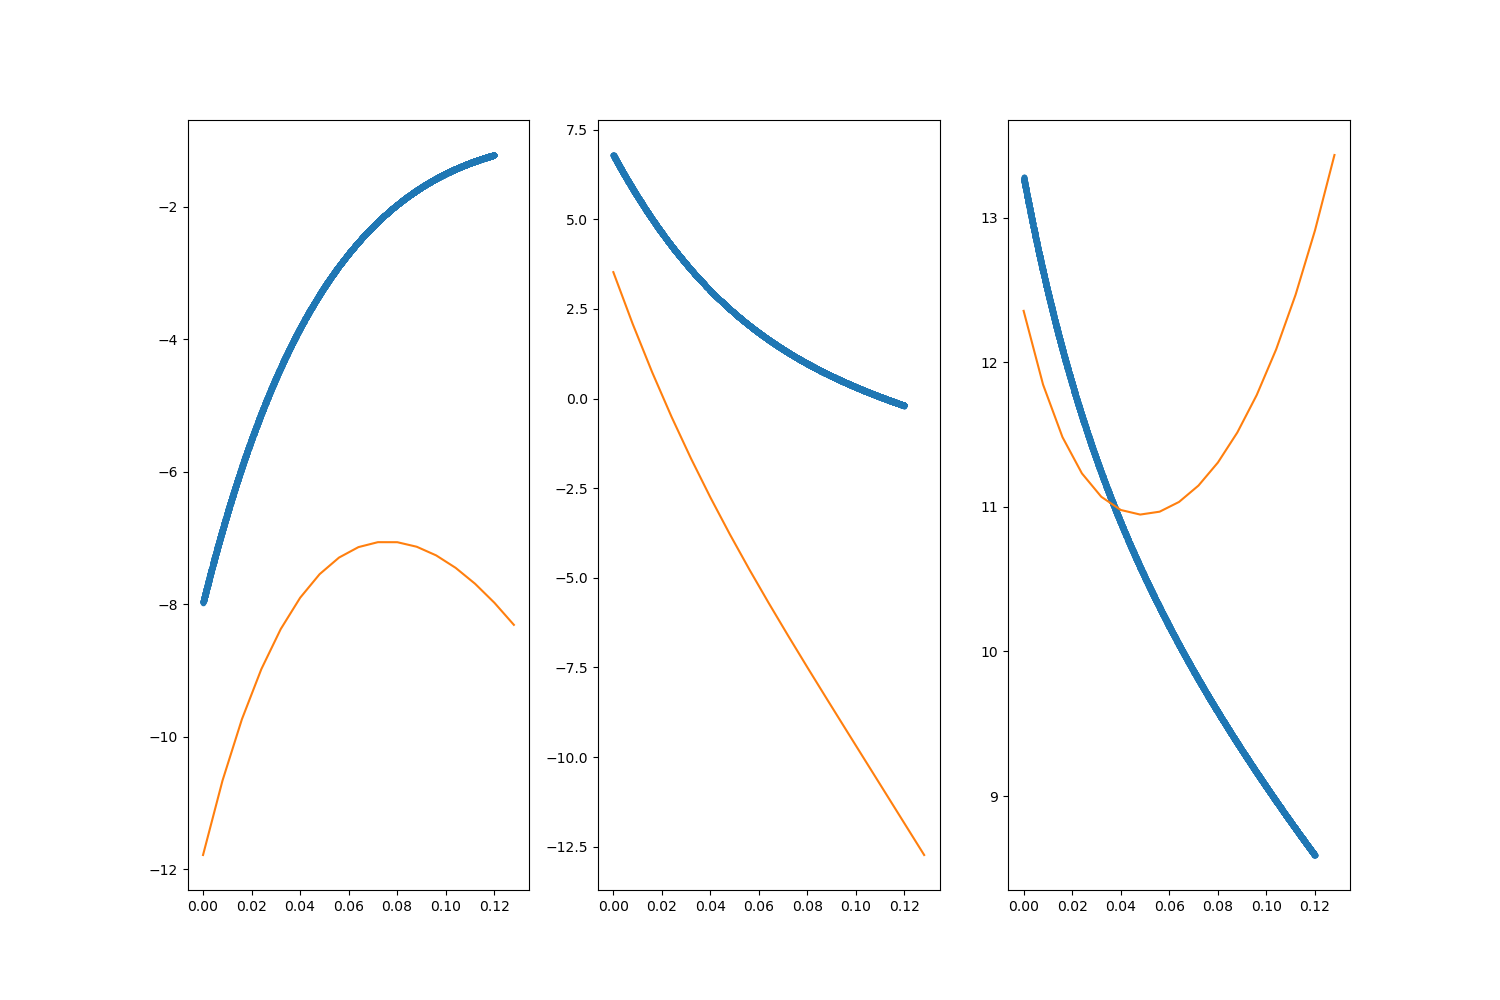

In [ ]:
# for each component plot the prediction and the real data
Y_pred4 = model4(X_sub_t4).detach().numpy()
plt.figure(figsize=(15, 10))
plt.subplot(131)
# no line for the x_pred
plt.plot(X_sub4, Y_pred4[:,0], label='x_pred', linestyle='None', marker='.')
plt.plot(X_sub, Y_sub[:,0], label='x_real')

plt.subplot(132)
plt.plot(X_sub4, Y_pred4[:,1], label='y_pred',linestyle='None', marker='.')
plt.plot(X_sub, Y_sub[:,1], label='y_real')

plt.subplot(133)
plt.plot(X_sub4, Y_pred4[:,2], label='z_pred',linestyle='None', marker='.')
plt.plot(X_sub, Y_sub[:,2], label='z_real')